In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

from keras import layers, models, backend, optimizers, regularizers
from keras.models import Model
from keras.callbacks import EarlyStopping

In [2]:
print(tf.__version__)

2.9.1


In [3]:
# Train and Test Image Directories
train_img_dir = "D:Development/Data_Science_Datasets/Monkeypox_skinlesion/OriginalImages/"
test_img_dir = "D:Development/Data_Science_Datasets/Monkeypox_skinlesion/Test/"
val_img_dir = "D:Development/Data_Science_Datasets/Monkeypox_skinlesion/Val/"

# Basic variables
val_batch_size = 51
val_img_height = 56
val_img_width = 56
val_validation_split = None
val_subset = None
val_shuffle = True
val_labels = 'inferred'
val_seed = 56
val_channels = 3
val_interpolation = 'gaussian'
val_steps_per_epochs = 90
val_learning_rate = 0.0003
val_epochs = 15

In [4]:
train_img_ds = tf.keras.utils.image_dataset_from_directory(
    train_img_dir,
    validation_split = val_validation_split,
    subset = val_subset,
    seed = val_seed,
    image_size=(val_img_height, val_img_width),
    batch_size = val_batch_size, 
    shuffle = val_shuffle,
    labels = val_labels,
    interpolation = val_interpolation)

Found 39168 files belonging to 2 classes.


In [5]:
test_img_ds = tf.keras.utils.image_dataset_from_directory(
    test_img_dir,
    validation_split = val_validation_split,
    subset = val_subset,
    seed = val_seed,
    image_size=(val_img_height, val_img_width),
    batch_size = val_batch_size, 
    shuffle = val_shuffle,
    labels = val_labels,
    interpolation = val_interpolation)

Found 45 files belonging to 2 classes.


In [6]:
val_img_ds = tf.keras.utils.image_dataset_from_directory(
    val_img_dir,
    validation_split = val_validation_split,
    subset = val_subset,
    seed = val_seed,
    image_size=(val_img_height, val_img_width),
    batch_size = val_batch_size, 
    shuffle = val_shuffle,
    labels = val_labels,
    interpolation = val_interpolation)

Found 406 files belonging to 2 classes.


In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [8]:
norm_train_img_ds = train_img_ds.map(lambda x, y: (normalization_layer(x), y))

In [9]:
norm_test_img_ds = test_img_ds.map(lambda x, y: (normalization_layer(x), y))

In [10]:
norm_val_img_ds = val_img_ds.map(lambda x, y: (normalization_layer(x), y))

In [11]:
class_names = train_img_ds.class_names
print(class_names)

['Monkeypox', 'Others']


In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                        input_shape=(val_img_height, val_img_width, val_channels)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2))) 

model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='sigmoid'))
model.add(layers.Dense(512, activation='sigmoid'))
model.add(layers.Dense(2))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                        

In [14]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(val_learning_rate, decay_steps = val_steps_per_epochs, 
                                                             decay_rate=1, staircase=False)

In [15]:
optimizer = optimizers.Adam(lr_schedule)

In [16]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='Sparse_CategoricalCrossentropy', patience=120)]

In [17]:
model.compile(optimizer = optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='Sparse_CategoricalCrossentropy'),
                       'accuracy'])

history = model.fit(norm_train_img_ds,  epochs = val_epochs, validation_data=(norm_val_img_ds), 
                    batch_size = val_batch_size, callbacks = callback)

Epoch 1/15
768/768 [==============================] - 170s 220ms/step - loss: 0.4853 - Sparse_CategoricalCrossentropy: 0.4853 - accuracy: 0.7523 - val_loss: 0.5694 - val_Sparse_CategoricalCrossentropy: 0.5691 - val_accuracy: 0.7192
Epoch 2/15
768/768 [==============================] - 167s 217ms/step - loss: 0.3737 - Sparse_CategoricalCrossentropy: 0.3737 - accuracy: 0.8274 - val_loss: 0.5717 - val_Sparse_CategoricalCrossentropy: 0.5719 - val_accuracy: 0.7463
Epoch 3/15
768/768 [==============================] - 168s 219ms/step - loss: 0.3212 - Sparse_CategoricalCrossentropy: 0.3212 - accuracy: 0.8612 - val_loss: 0.5690 - val_Sparse_CategoricalCrossentropy: 0.5686 - val_accuracy: 0.7709
Epoch 4/15
768/768 [==============================] - 167s 218ms/step - loss: 0.2897 - Sparse_CategoricalCrossentropy: 0.2897 - accuracy: 0.8798 - val_loss: 0.5890 - val_Sparse_CategoricalCrossentropy: 0.5877 - val_accuracy: 0.7808
Epoch 5/15
768/768 [==============================] - 176s 229ms/step - 

Text(0.5, 1.0, 'CNN 2-Layer Learning-rate 3e-4')

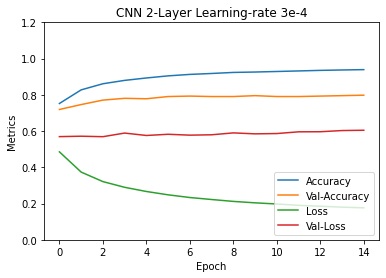

In [21]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val-Accuracy')
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Val-Loss')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.ylim([0.0, 1.2])
plt.legend(loc='lower right')
plt.title('CNN 2-Layer Learning-rate 3e-4')

In [22]:
test_loss, test_sparse_entropy, test_acc = model.evaluate(test_img_ds,  verbose=2)
print(test_acc)

1/1 - 0s - loss: 0.8332 - Sparse_CategoricalCrossentropy: 0.8332 - accuracy: 0.6000 - 444ms/epoch - 444ms/step
0.6000000238418579


In [23]:
test_loss, test_sparse_entropy, test_acc = model.evaluate(norm_test_img_ds,  verbose=2)
print(test_acc)

1/1 - 0s - loss: 0.3407 - Sparse_CategoricalCrossentropy: 0.3407 - accuracy: 0.9333 - 102ms/epoch - 102ms/step
0.9333333373069763
